In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.utils import shuffle
import time

In [ ]:
!pip install qiskit-aqua==0.7
from qiskit.ml.datasets import ad_hoc_data, breast_cancer
from qiskit.aqua import aqua_globals
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit.aqua.algorithms import SklearnSVM

In [ ]:
def convertData(training_size, test_size, n, gap, plot_data): 
  class_labels = [r'A', r'B']
  data = pd.read_csv('/content/dataset_competition_IBM.csv')
  data = shuffle(data.values, random_state=0)
  # print(data[:,data.shape[1]-1])
  sample_train, sample_test, label_train, label_test = \
      train_test_split(data[:,0:data.shape[1]-1], data[:,data.shape[1]-1], test_size=0.3, random_state=12)
  print(label_train)
  # Now we standardize for gaussian around 0 with unit variance
  std_scale = StandardScaler().fit(sample_train)
  sample_train = std_scale.transform(sample_train)
  sample_test = std_scale.transform(sample_test)

  # Now reduce number of features to number of qubits
  pca = PCA(n_components=n).fit(sample_train)
  sample_train = pca.transform(sample_train)
  sample_test = pca.transform(sample_test)

  # Scale to the range (-1,+1)
  samples = np.append(sample_train, sample_test, axis=0)
  minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
  sample_train = minmax_scale.transform(sample_train)
  sample_test = minmax_scale.transform(sample_test)

  # Pick training size number of samples from each distro
  training_input = {key: (sample_train[label_train == k, :])[:training_size]
                    for k, key in enumerate(class_labels)}
  test_input = {key: (sample_test[label_test == k, :])[:test_size]
                for k, key in enumerate(class_labels)}

  if plot_data:
      try:
          import matplotlib.pyplot as plt
      except ImportError:
          raise NameError('Matplotlib not installed. Please install it before plotting')
      for k in range(0, 2):
          plt.scatter(sample_train[label_train == k, 0][:training_size],
                      sample_train[label_train == k, 1][:training_size])

      plt.title("PCA dim. reduced dataset")
      plt.show()

  return sample_train, training_input, test_input, class_labels

[1. 1. 0. ... 1. 1. 0.]


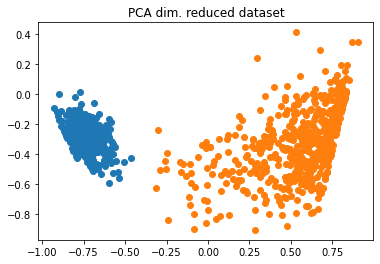

In [18]:
sample_Total, training_input, test_input, class_labels = convertData(training_size=500, test_size=100, n = 2, gap = 0.3, plot_data =True)

In [19]:
%time result = SklearnSVM(training_input, test_input).run()

print("testing success ratio: ", result['testing_accuracy'])

CPU times: user 6.09 s, sys: 2.08 s, total: 8.16 s
Wall time: 4.16 s
testing success ratio:  1.0


Data points: (200, 40)
Accuracy (test): 1.0
Time: 518ms, 

In [21]:
acc_test = [1.0, 1.0, 1.0, 1.0, 1.0]
time = [299/1000, 1.06, 1.95, 4.84, 8.16]
data_points = [(100, 20), (200, 40), (300, 60), (400, 80), (500, 100)]

pd.DataFrame({'Acc_test': acc_test, 'Time (s)': time, 'data_points': data_points})

,Acc_test,Time (s),data_points
0,1.0,0.299,"(100, 20)"
1,1.0,1.060,"(200, 40)"
2,1.0,1.950,"(300, 60)"
3,1.0,4.840,"(400, 80)"
4,1.0,8.160,"(500, 100)"
